In [36]:
# Import related packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import math


In [40]:
# Import trainset and testset
project_dir = '../House Price/'
trainset = pd.read_csv(project_dir + 'train.csv')
testset = pd.read_csv(project_dir + 'test.csv')

In [41]:
trainset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [42]:
# Check the number of rows and columns in the trainset
print(f'There are {trainset.shape[0]} rows and {trainset.shape[1]} columns in the trainset.')

There are 1460 rows and 81 columns in the trainset.


In [43]:
# Print the column with missing value
missing_values = trainset.isnull().sum()
for column, missing in missing_values.items():
    if missing != 0:
        print(f'{column}: {missing}')

LotFrontage: 259
Alley: 1369
MasVnrType: 872
MasVnrArea: 8
BsmtQual: 37
BsmtCond: 37
BsmtExposure: 38
BsmtFinType1: 37
BsmtFinType2: 38
Electrical: 1
FireplaceQu: 690
GarageType: 81
GarageYrBlt: 81
GarageFinish: 81
GarageQual: 81
GarageCond: 81
PoolQC: 1453
Fence: 1179
MiscFeature: 1406


In [44]:
# Drop columns with lots of missing values
trainset.drop(['Id', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1, inplace = True)

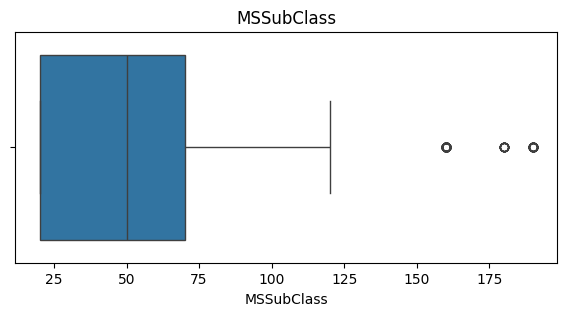

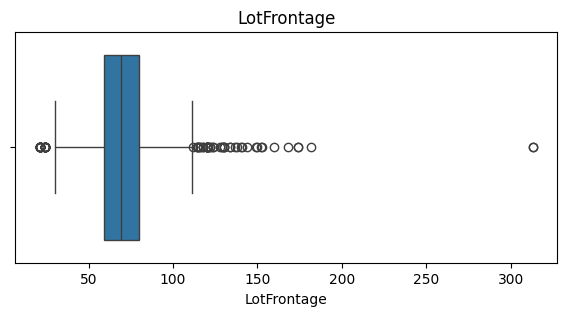

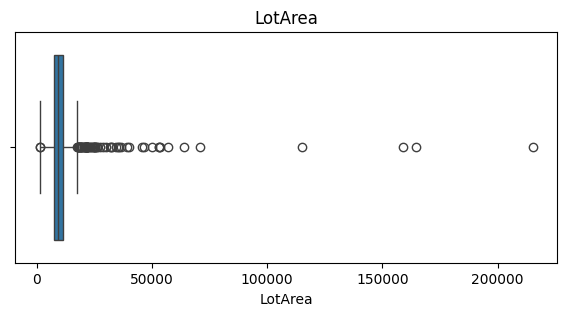

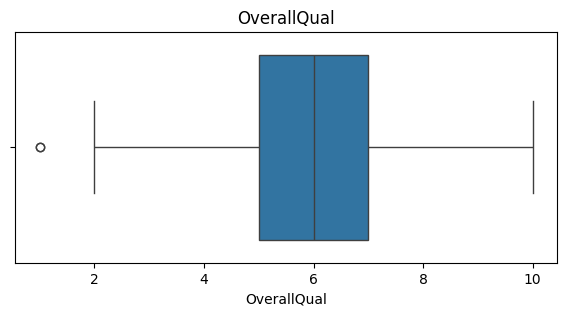

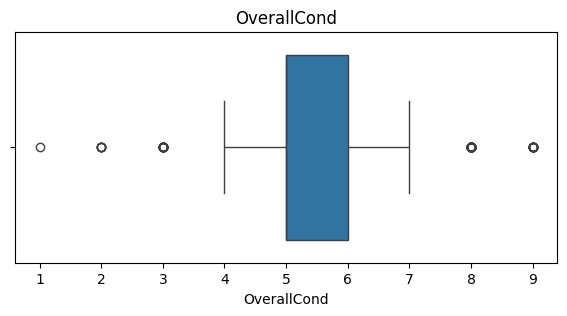

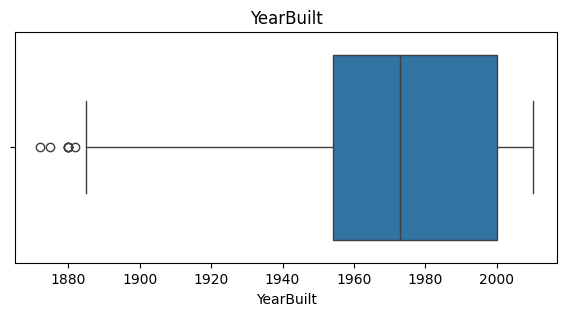

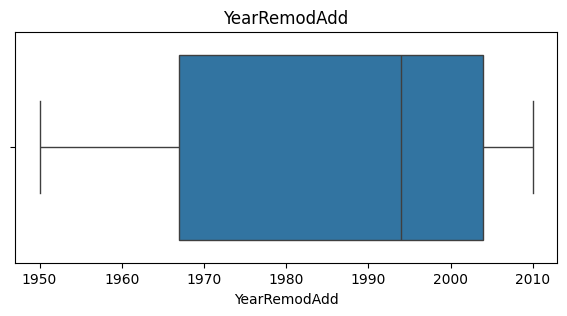

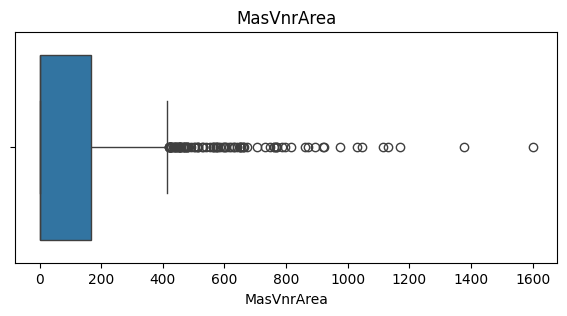

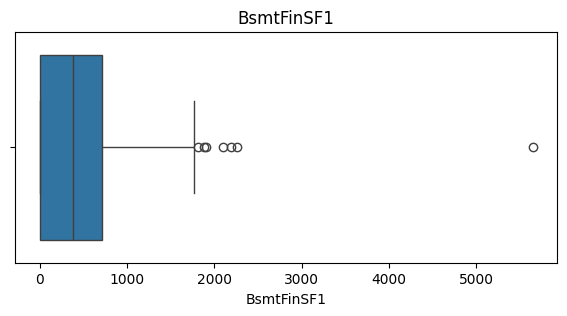

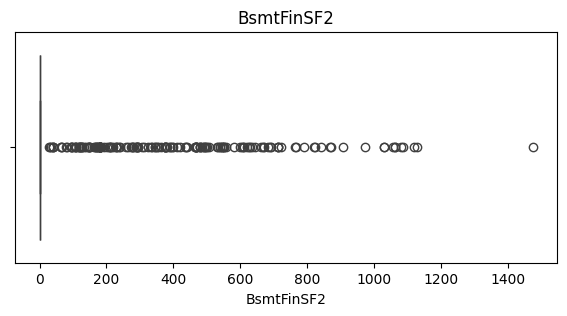

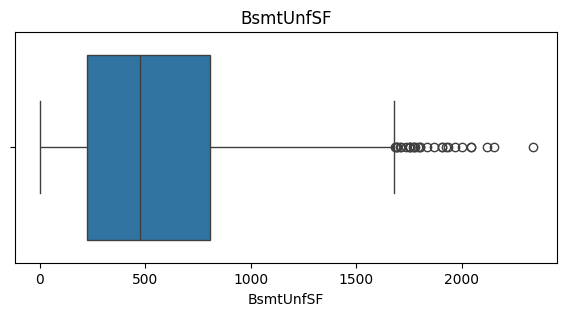

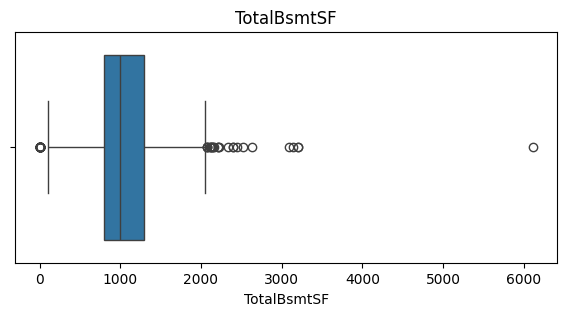

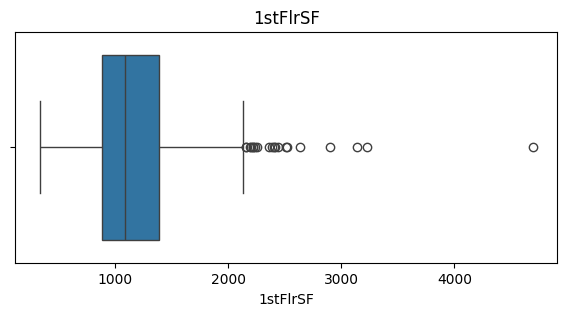

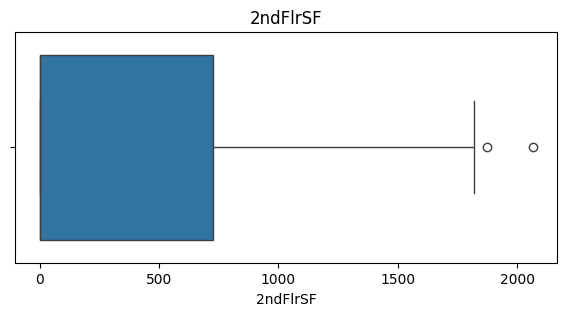

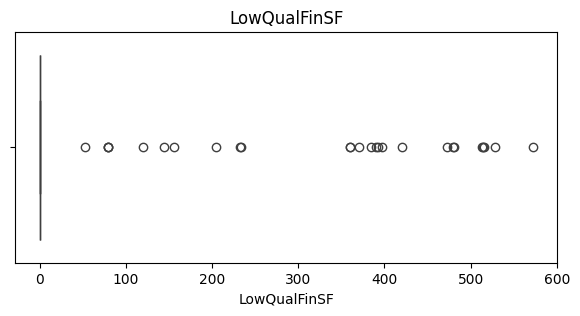

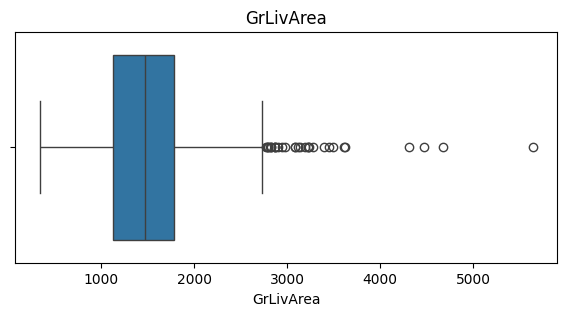

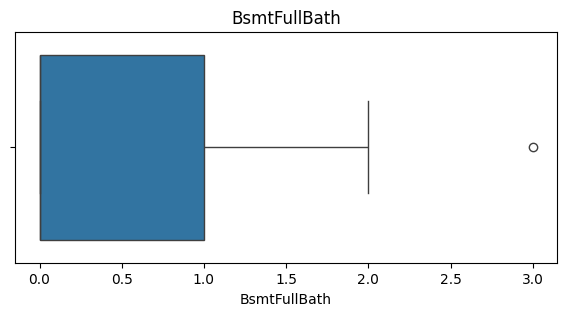

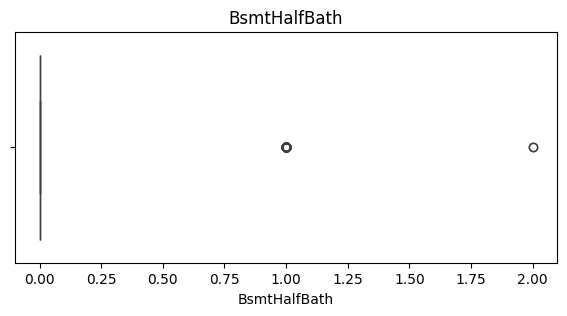

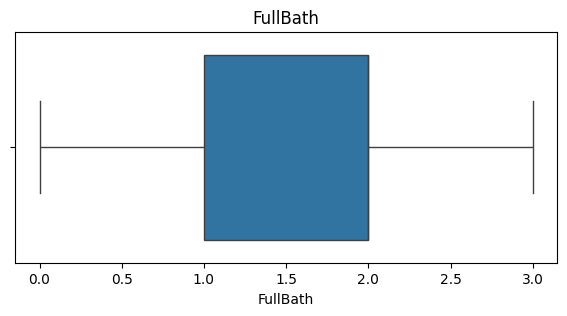

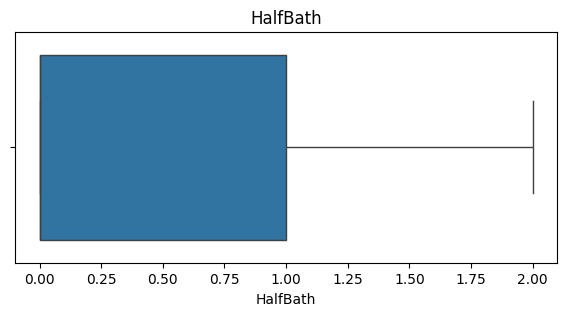

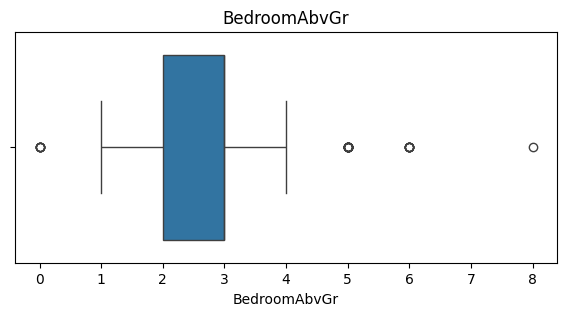

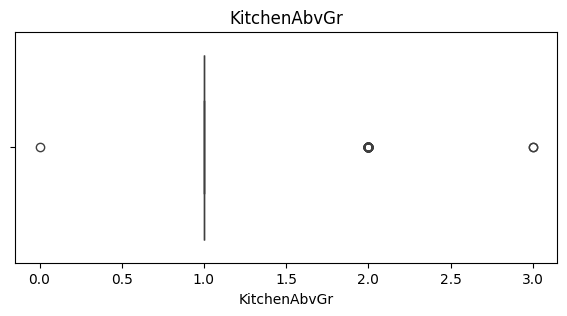

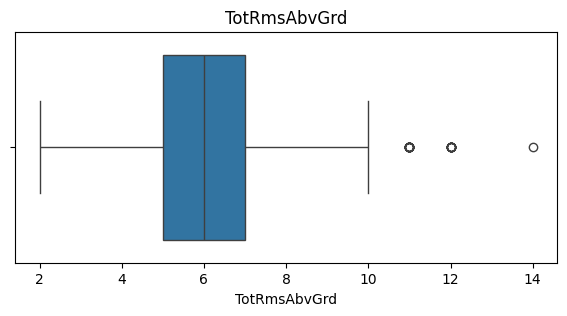

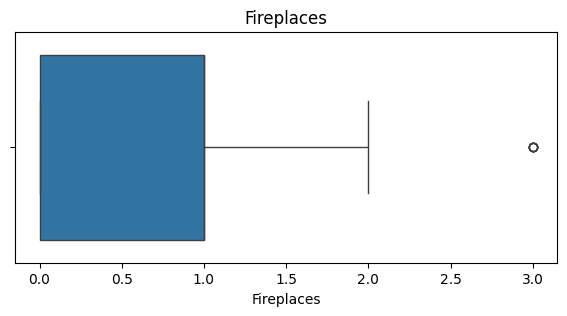

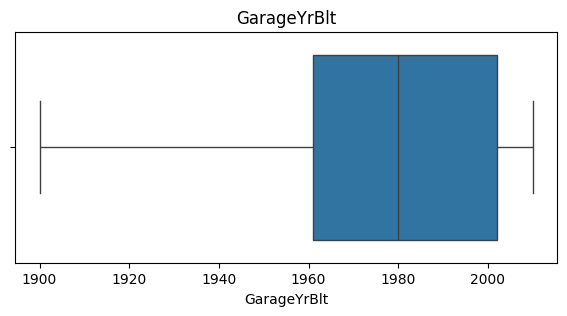

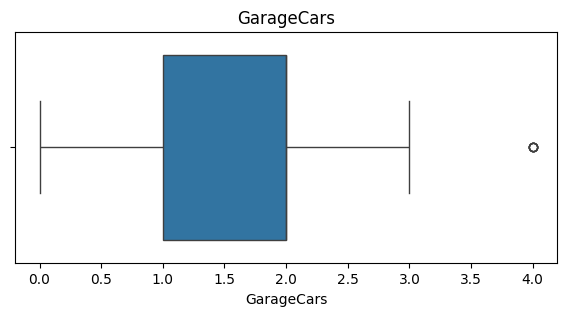

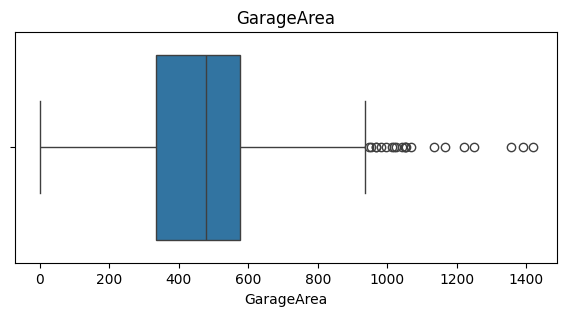

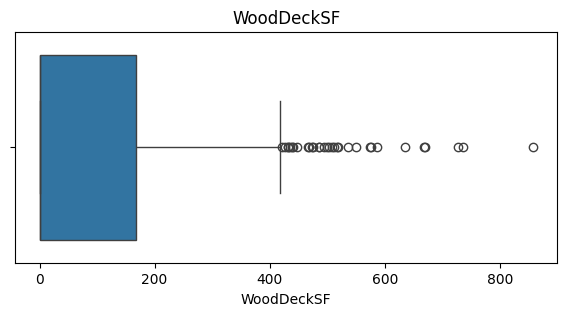

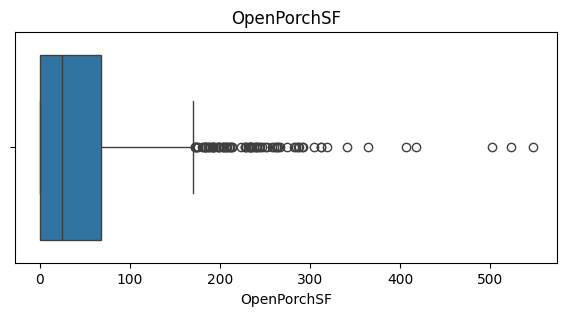

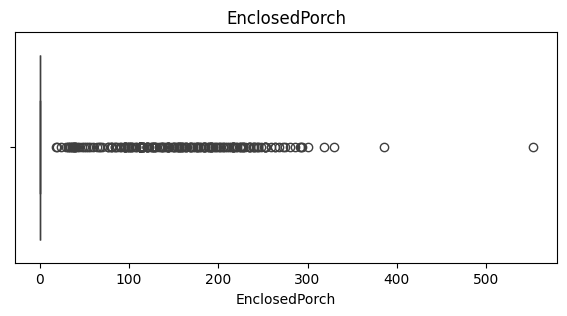

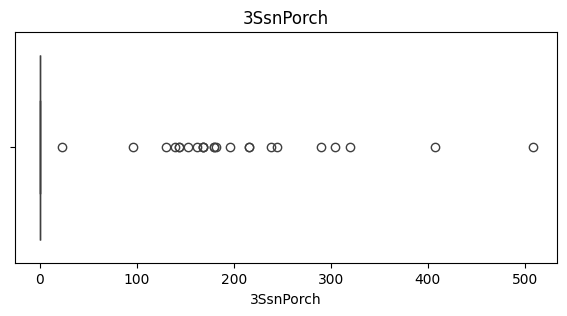

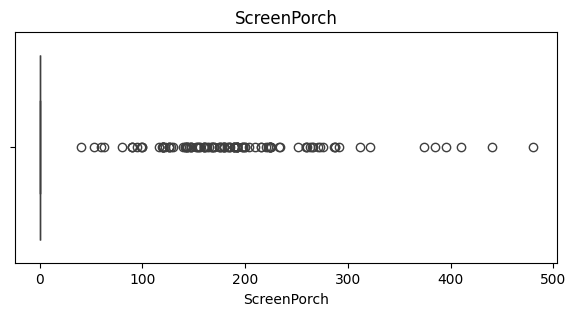

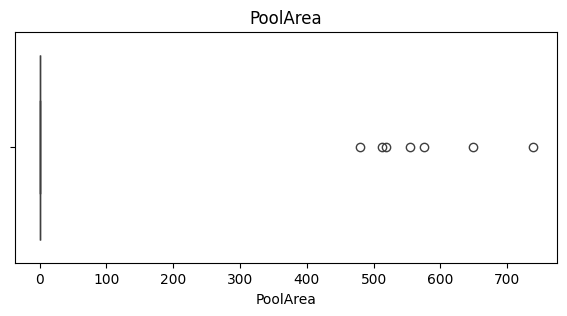

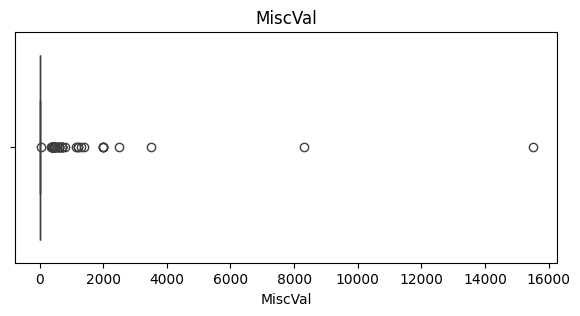

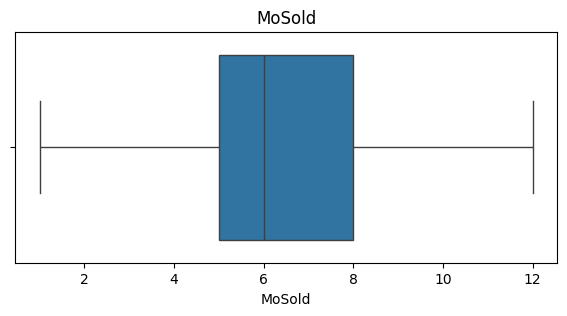

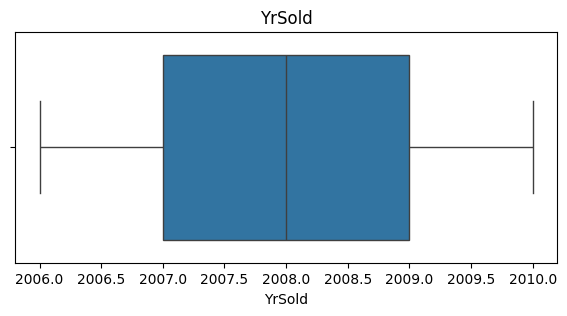

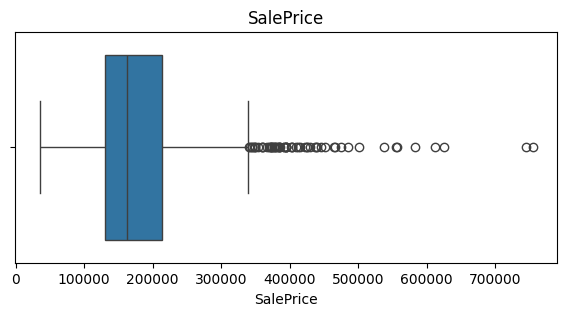

In [45]:
# Draw boxplots for numerical features
numerical_columns = trainset.select_dtypes(include=['number'])
for column in numerical_columns:
    plt.figure(figsize=(7, 3))
    sns.boxplot(x=trainset[column])
    plt.title(column)
    plt.show()


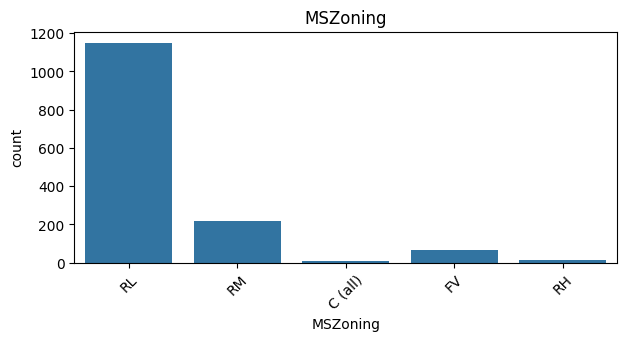

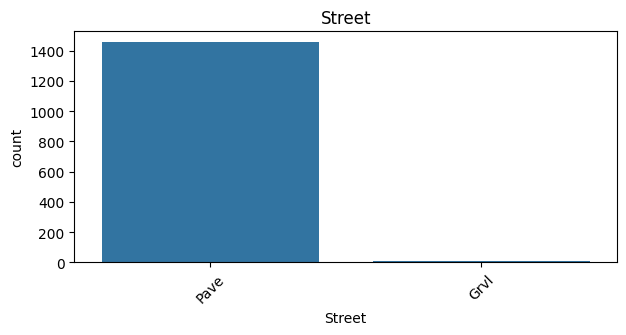

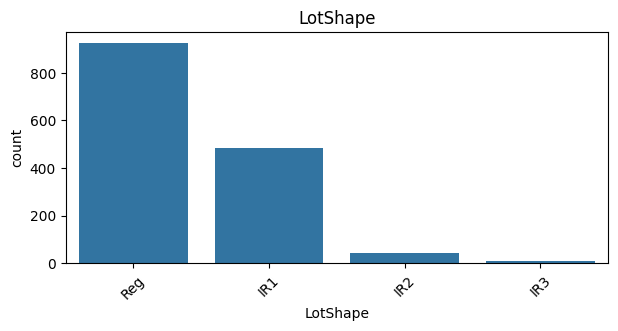

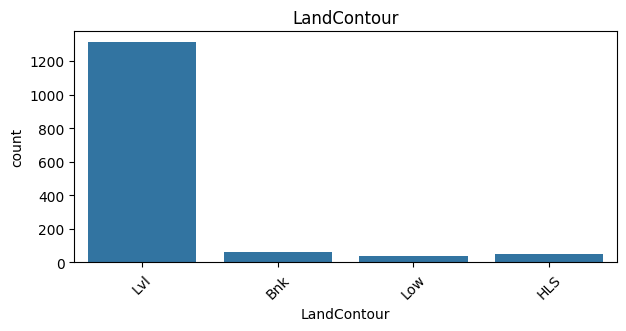

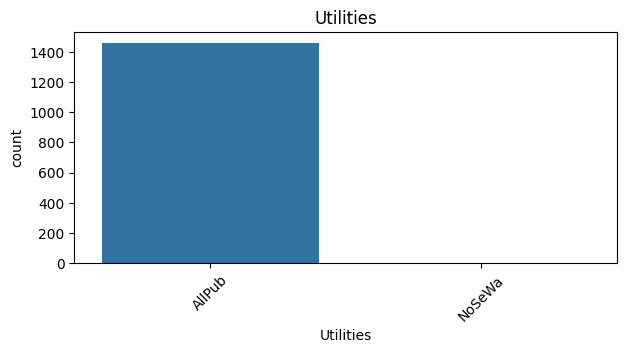

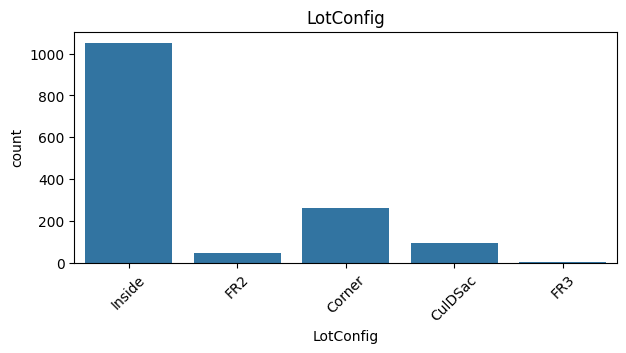

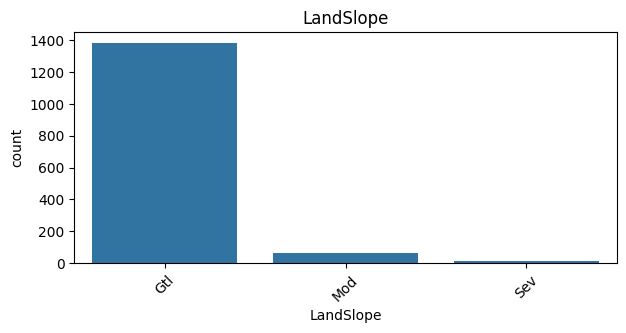

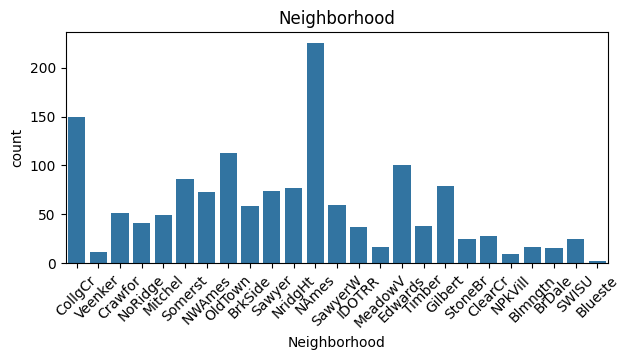

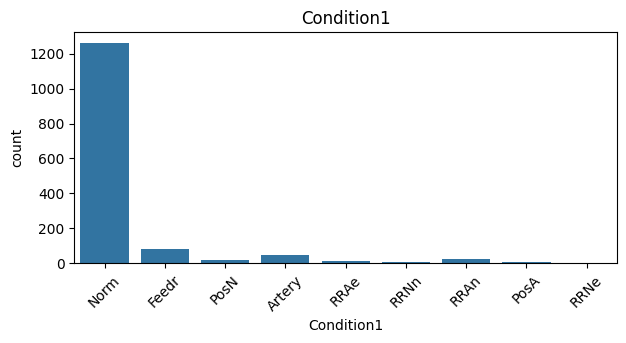

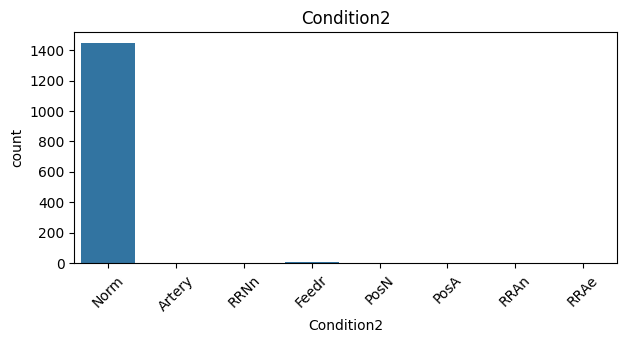

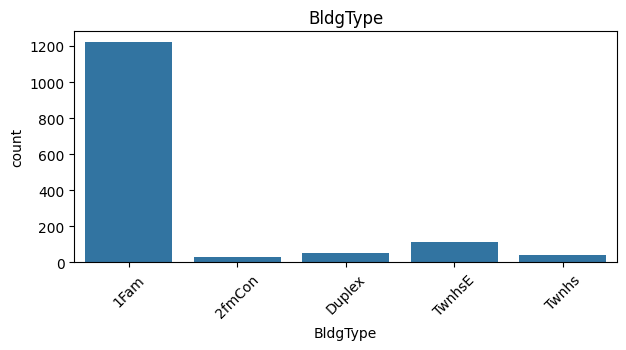

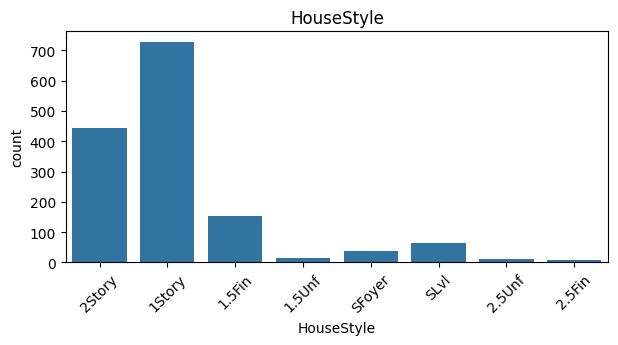

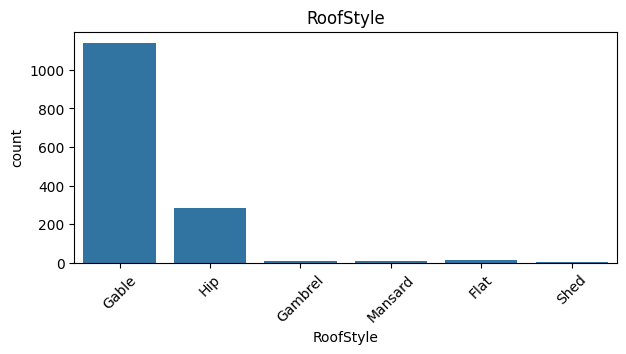

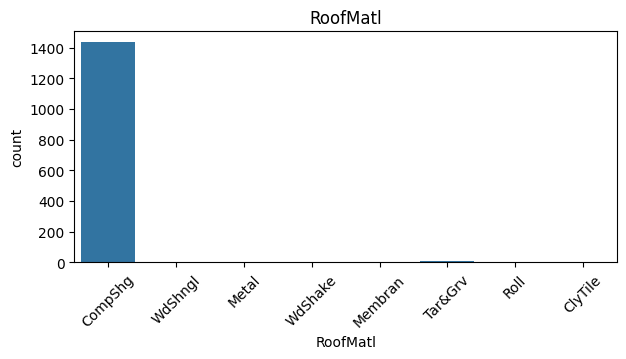

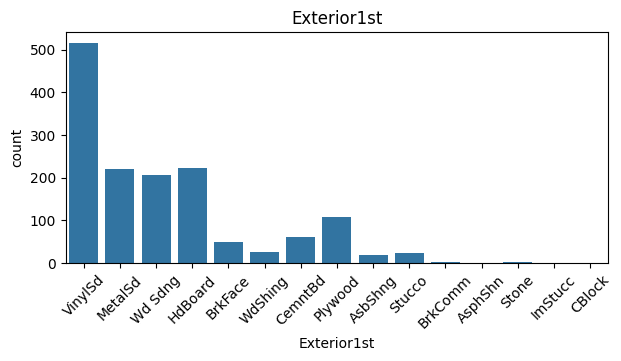

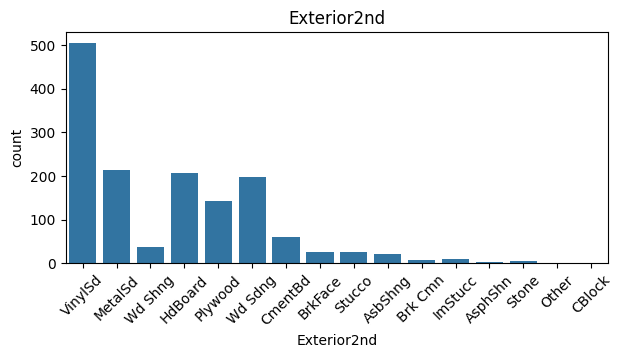

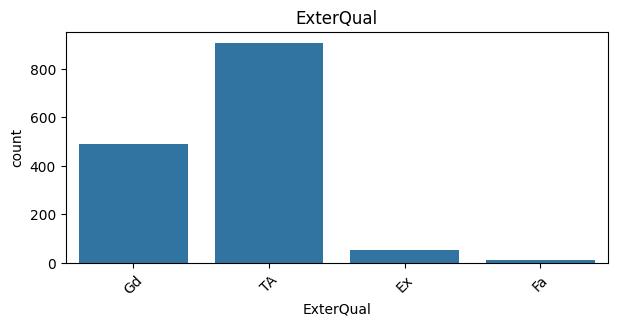

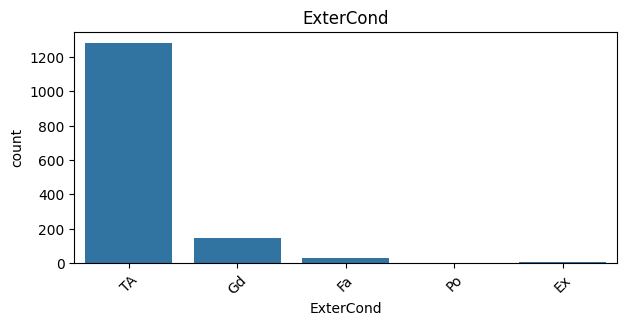

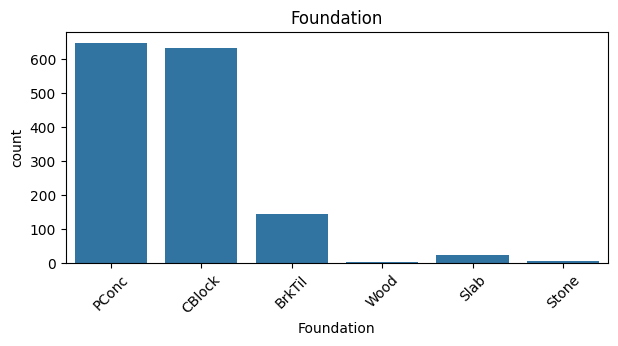

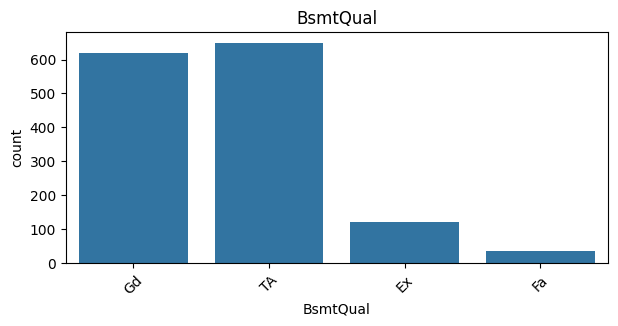

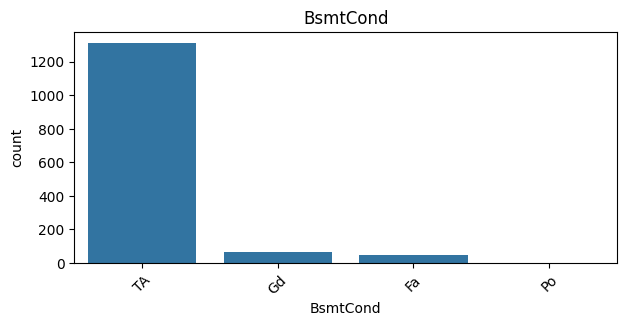

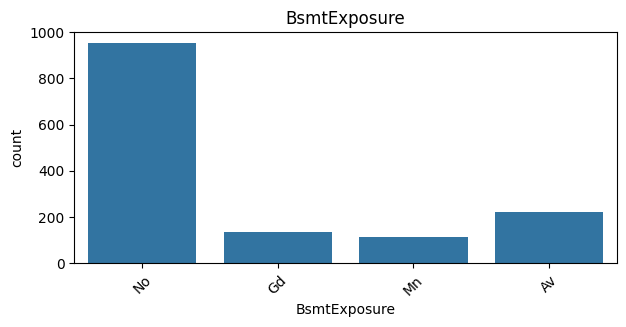

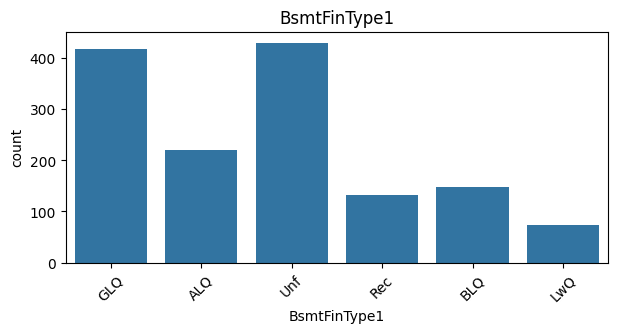

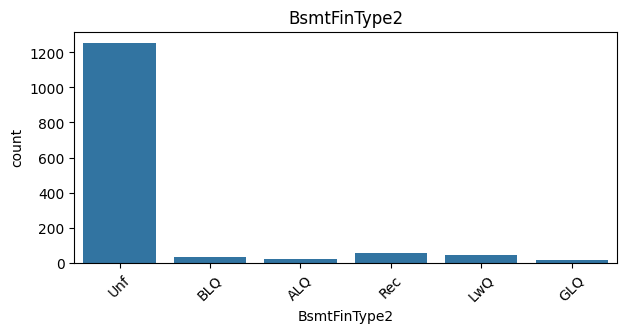

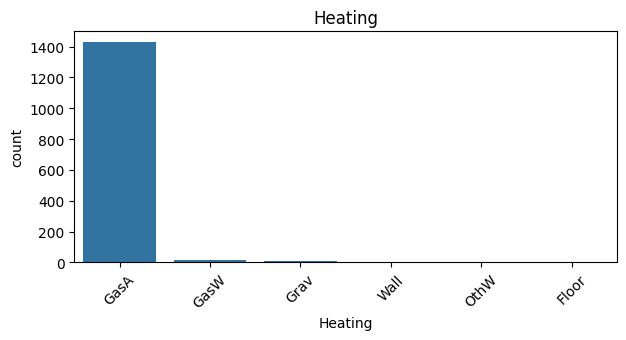

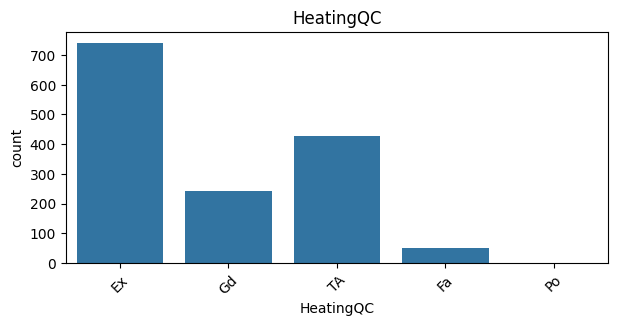

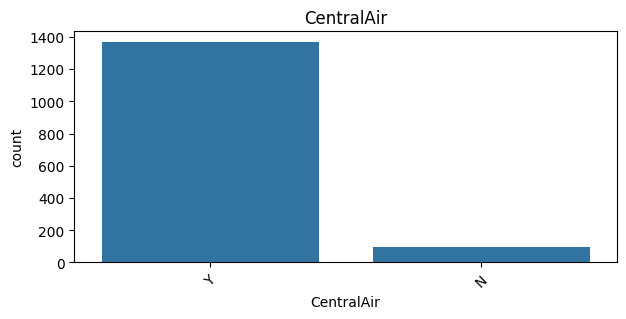

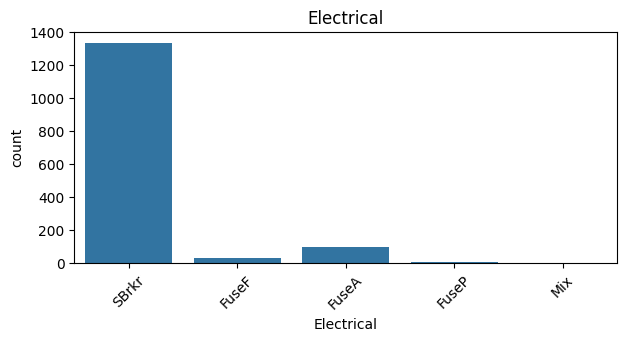

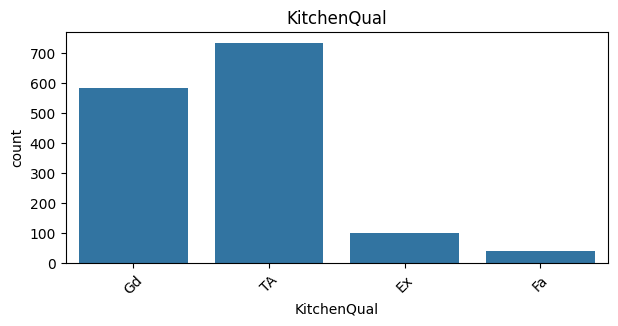

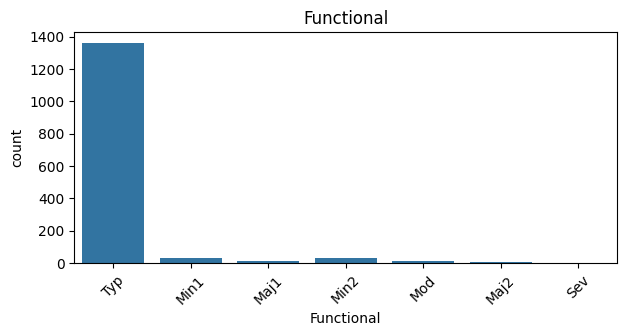

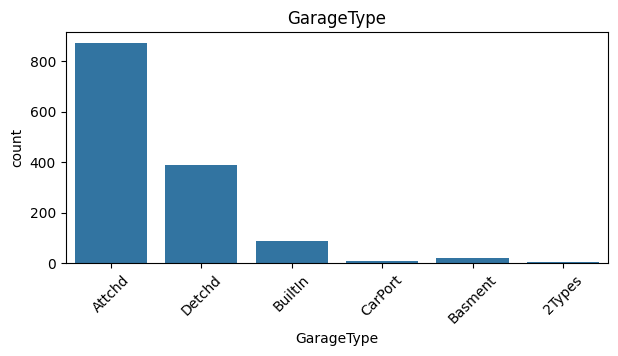

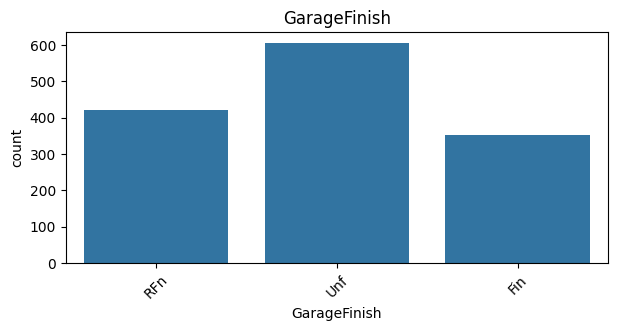

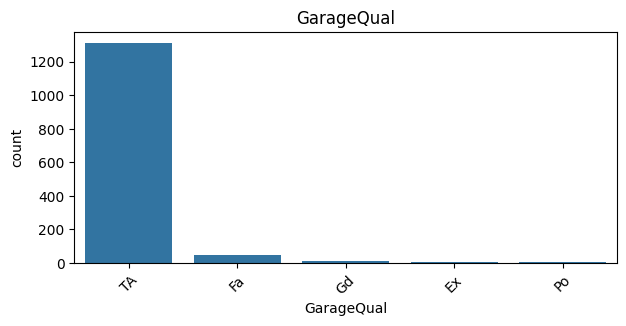

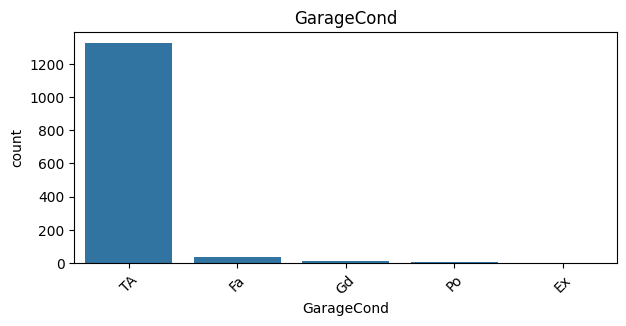

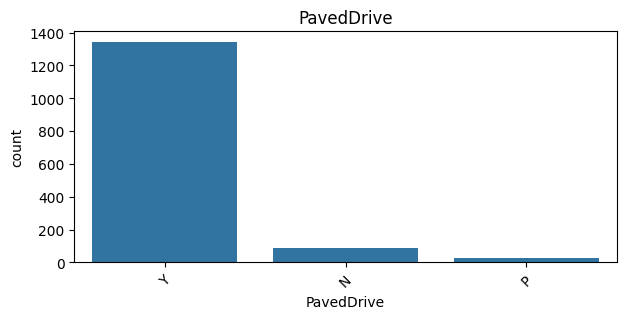

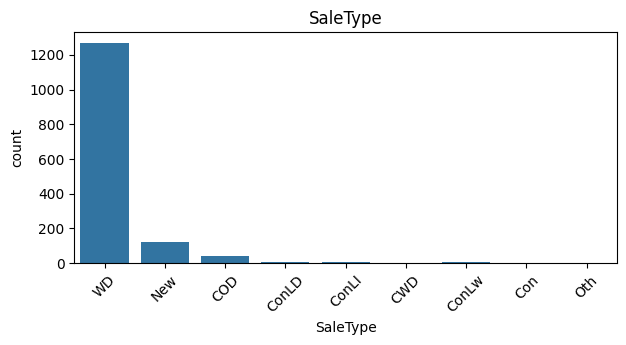

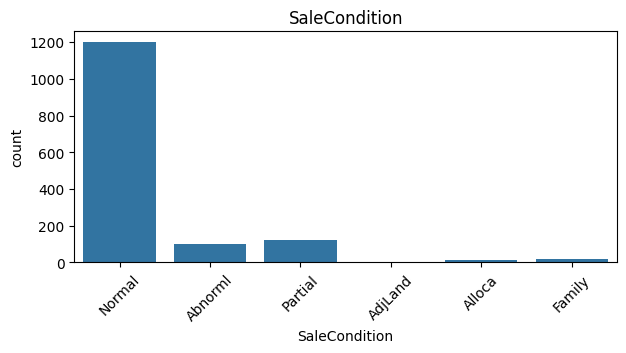

In [50]:
# Draw histograms for categorical features
categorical_columns = trainset.select_dtypes(include=['object'])
for column in categorical_columns:
    plt.figure(figsize=(7, 3))
    sns.countplot(x=column, data=trainset)
    plt.title(column)
    plt.xticks(rotation=45)
    plt.show()


In [51]:
trainset.drop(['Street', 'Utilities', 'Condition2', 'RoofMatl'], axis = 1, inplace = True)